# Knowledge Graph Builder

Explore Wikipedia to create knowledge graphs around specific terms of interest.

This notebook is based on the tutorial https://towardsdatascience.com/nlp-with-python-knowledge-graph-12b93146a458



##1. Setup : Downloading and importing necessary packages

In [ ]:
!pip install wikipedia

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11680 sha256=9f752eacb9232b4a3414fed49a7f15f1bcb4be39296d68339a1fbf18c0502702
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
!pip install textacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.0 MB/s eta 0:00:00


In [ ]:
!pip install dateparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 5.4 MB/s eta 0:00:00


In [ ]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt

## for text
import wikipedia
import nltk
import re

## for nlp
import spacy
from spacy import displacy
import textacy

## for graph
import networkx as nx

## for timeline
# we are not using this. If you are interested in additional analysis, example of how this can be used is given in the link above
import dateparser

Let's say I am interested to create a knowledge graph of the world war 2. I choose to start with the wikipedia page on this topic. The steps involved in creating a knowledge graph for this are:

1. Extract the text from the Wikipedia page
2. Analyse the text to extract the entities and their relationships
3. Visualize the knowledge graph

## 1. Extract the text from the Wikipedia page

Here, using the wikipedia module in Python, we extract the page with the title 'World War II'. We are interested in the text till the 'See also' section. Hence, everything after that is excluded. To check, we print out the first 200 characters of the extracted page.

In [ ]:
topic = "World War II"

page = wikipedia.page(topic)
#page = wiki.page(topic)
txt = page.content[:page.content.find("See also")]
txt[0:200] + " ..."

'World War I or the First World War (28 July 1914 – 11 November 1918) was a global conflict between two coalitions: the Allies (or Entente) and the Central Powers. Fighting took place mainly in Europe  ...'

## 2. Analyse the text to extract the entities and their relationships

We use the Python library SpaCy to extract entities and their relationships. SpaCy is an open-cource Python library with features for several text processing tasks such as Named Entity Recognition, Parts-of-Speech tagging, vectors for words etc.  

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

In [ ]:
# from text to a list of sentences
lst_docs = [sent for sent in doc.sents]
print("how many sentences in the wiki page:", len(lst_docs))

how many sentences in the wiki page: 597


Here we create a dictionary with the sentence, entity, relationship and object. We make use the Python library Textacy (built on top of SpaCy) to extract subject,verb,object tuples from text.

We make use the heuristic to have subjects and objects as entities in the knowledge graph and the verbs as relations in the knowledge graph. If you would like to experiment a little, please make changes in the code to have different conditions to choose entities and relations.

In [ ]:
## extract entities and relations
dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}

for n,sentence in enumerate(lst_docs):
    lst_generators = list(textacy.extract.subject_verb_object_triples(sentence))
    for sent in lst_generators:
        subj = "_".join(map(str, sent.subject))
        obj  = "_".join(map(str, sent.object))
        relation = "_".join(map(str, sent.verb))
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic["entity"].append(subj)
        dic["object"].append(obj)
        dic["relation"].append(relation)

Let's put it all in a dataframe for easy processing

In [ ]:
kgDf = pd.DataFrame(dic)

Let's see how it looks

In [ ]:
kgDf.head()

,id,text,entity,relation,object
0,1,Fighting took place mainly in Europe and the M...,Fighting,took,place_parts_Asia_Pacific
1,1,Fighting took place mainly in Europe and the M...,Fighting,was_characterised,trench_warfare_use
2,4,The causes of World War I included the rise of...,causes_I,included,rise_decline_competition
3,4,The causes of World War I included the rise of...,which,disturbed,balance
4,5,Growing tensions between the great powers and ...,tensions,reached,point


We see 'which' as an entity. Let's improve the knowledge graph a bit by removing English stopwords such as these from entities

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stops =  list(stopwords.words('english'))
kgDf = kgDf[~kgDf['entity'].isin(stops)]
kgDf = kgDf[~kgDf['object'].isin(stops)]
## example
kgDf.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,text,entity,relation,object
0,1,Fighting took place mainly in Europe and the M...,Fighting,took,place_parts_Asia_Pacific
1,1,Fighting took place mainly in Europe and the M...,Fighting,was_characterised,trench_warfare_use
2,4,The causes of World War I included the rise of...,causes_I,included,rise_decline_competition
4,5,Growing tensions between the great powers and ...,tensions,reached,point
5,5,Growing tensions between the great powers and ...,Serb,assassinated,Archduke_Franz_Ferdinand


In [ ]:
## extract attributes
#attribute = "DATE"
#dic = {"id":[], "text":[], attribute:[]}

#for n,sentence in enumerate(lst_docs):
#    lst = list(textacy.extract.entities(sentence, include_types={attribute}))
#    if len(lst) > 0:
#        for attr in lst:
#            dic["id"].append(n)
#            dic["text"].append(sentence.text)
#            dic[attribute].append(str(attr))
#    else:
#        dic["id"].append(n)
#        dic["text"].append(sentence.text)
#        dic[attribute].append(np.nan)

#dtf_att = pd.DataFrame(dic)
#dtf_att = dtf_att[~dtf_att[attribute].isna()]



## 3. Visualize the knowledge graphs

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


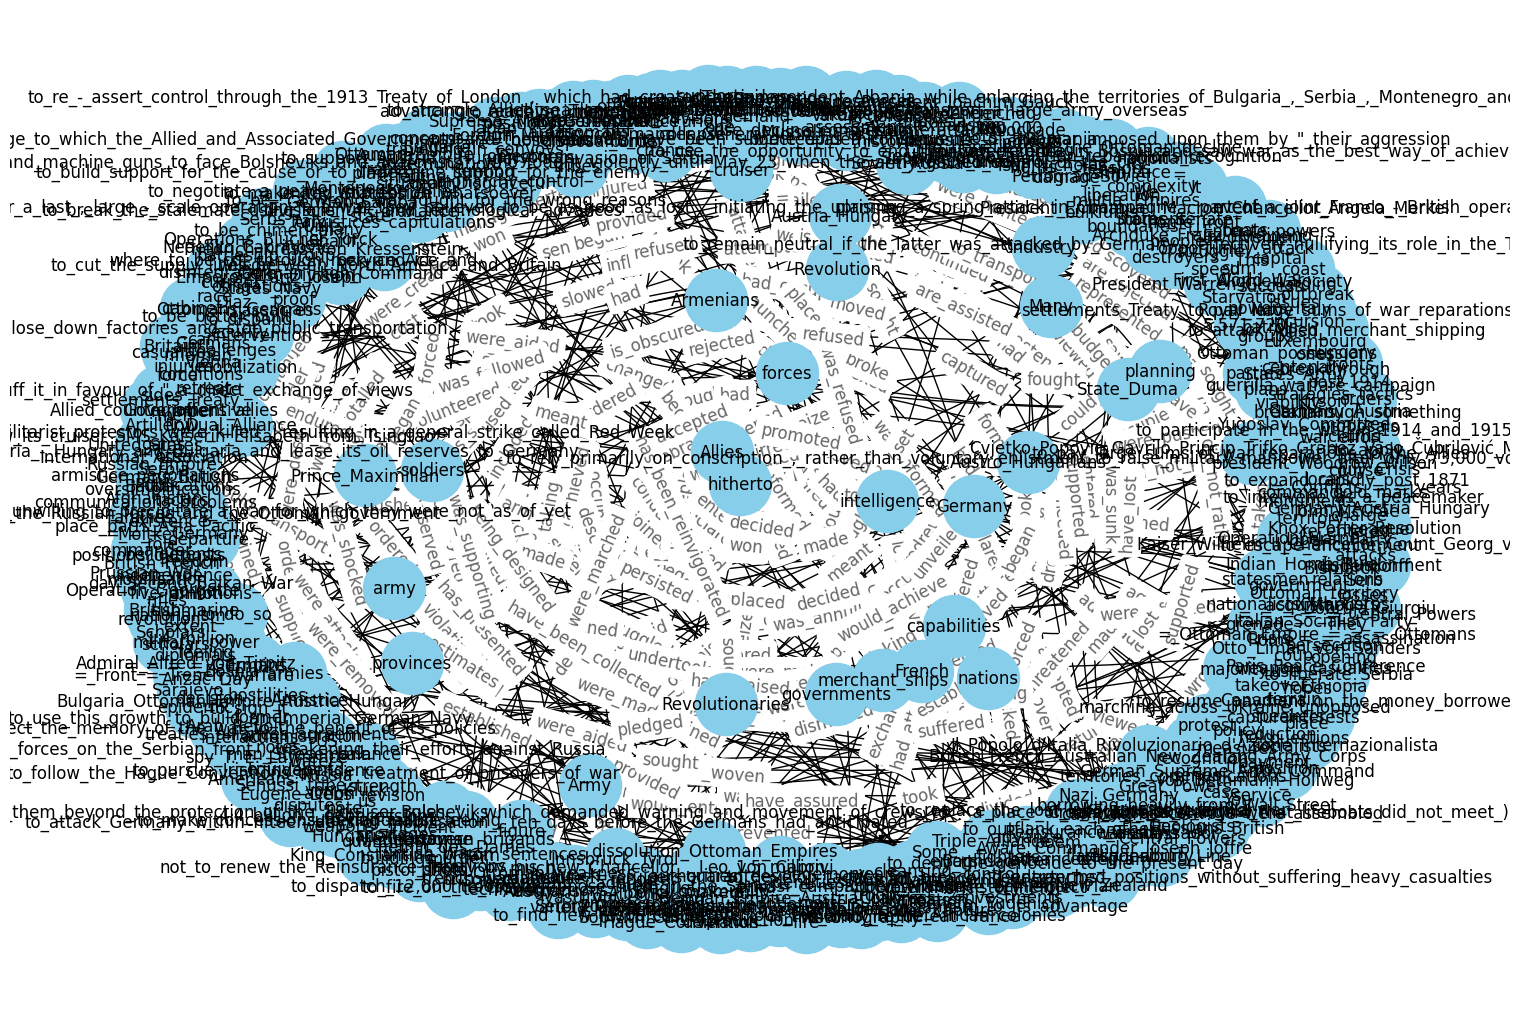

In [ ]:
G = nx.from_pandas_edgelist(kgDf, source="entity", target="object",
                            edge_attr="relation",
                            create_using=nx.DiGraph())


## plot
plt.figure(figsize=(15,10))

pos = nx.spring_layout(G, k=1)
node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color,
        edge_color=edge_color, cmap=plt.cm.Dark2,
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5,
                         edge_labels=nx.get_edge_attributes(G,'relation'),
                         font_size=12, font_color='black', alpha=0.6)
plt.show()

This looks very messy. Let's look at the nodes with most number of connections and just visualize one

In [ ]:
kgDf["entity"].value_counts().head()

entity
Germany            25
forces             13
Britain             8
Austria_Hungary     7
Romania             7
Name: count, dtype: int64

/usr/local/lib/python3.10/dist-packages/networkx/drawing/nx_pylab.py:450: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


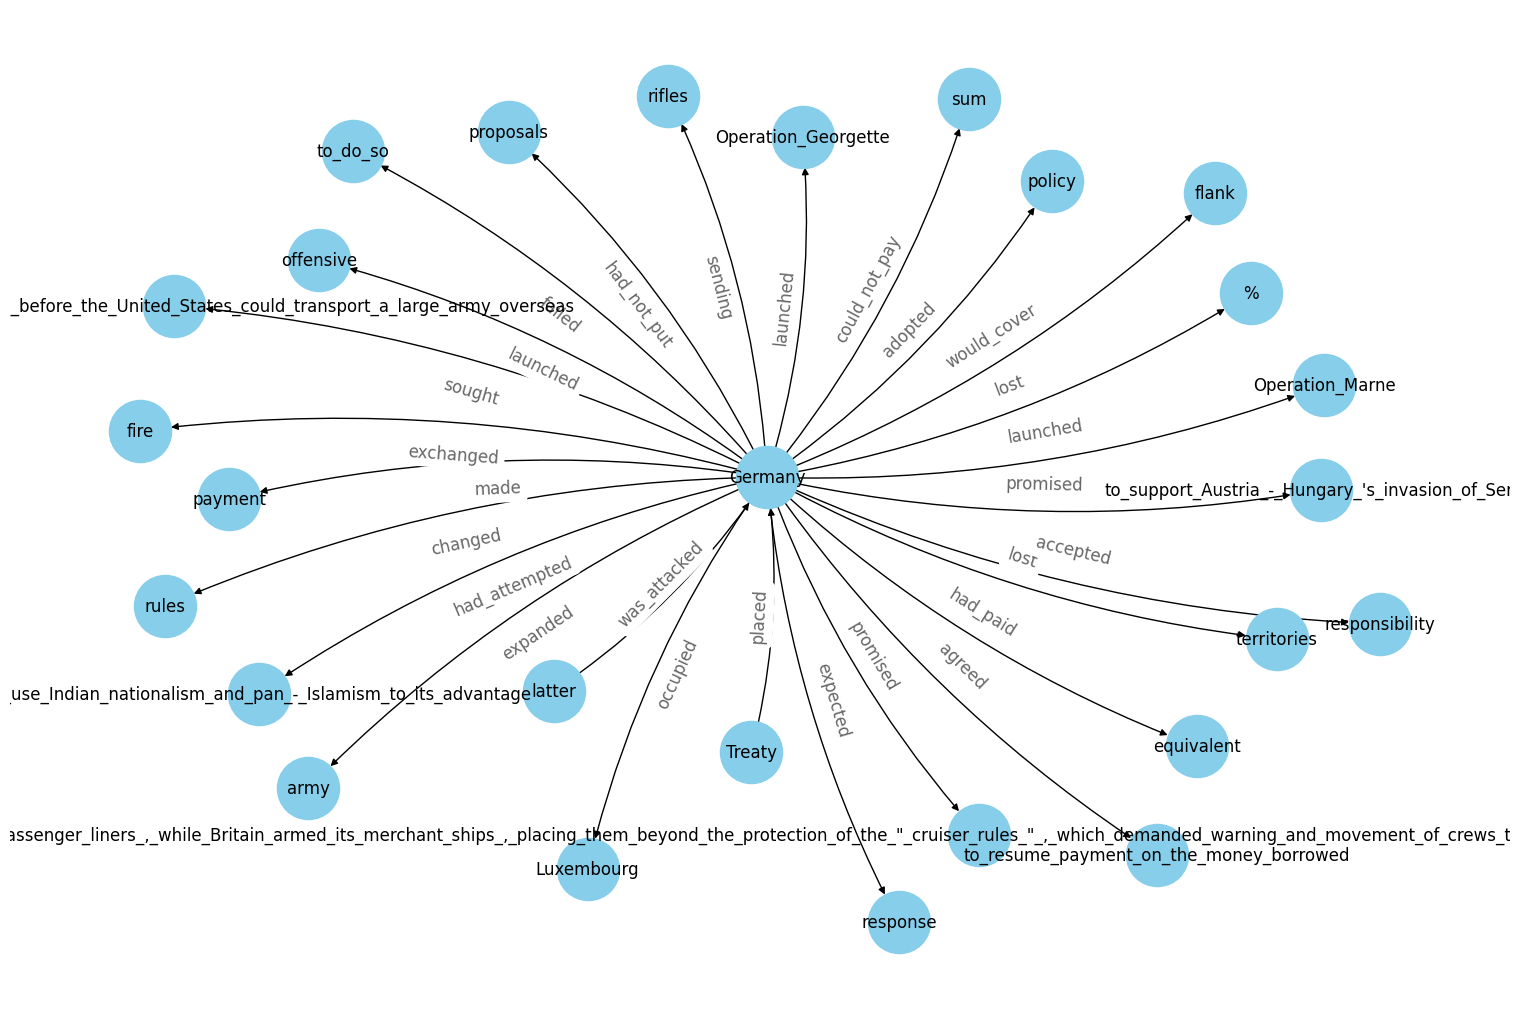

In [ ]:

f = "Germany"
tmp = kgDf[(kgDf["entity"]==f) | (kgDf["object"]==f)]


## create small graph
G = nx.from_pandas_edgelist(tmp, source="entity", target="object",
                            edge_attr="relation",
                            create_using=nx.DiGraph())

## plot
plt.figure(figsize=(15,10))

pos = nx.spring_layout(G, k=1)
node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color,
        edge_color=edge_color, cmap=plt.cm.Dark2,
        node_size=2000, connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5,
                         edge_labels=nx.get_edge_attributes(G,'relation'),
                         font_size=12, font_color='black', alpha=0.6)
plt.show()